# Trigger efficiency for Data

##### In this notebook I want to compute the probability for an event with 2 or more lepton jets to contain at least 2 trigger objects from at least one of the following trigger paths:

        - "HLT_DoubleL2Mu23NoVtx_2Cha",
        - "HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched",
        - "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed",
        - "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched",
        - "HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4",
        - "HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4",


##### The computation is divided into 2 parts (the study of Delta R is just a test):
- computing per-object efficiency: probability for a lepton jet (LJ) to contain at least 1 trigger objects (TOs). Using tag and probe method (this part is completed)

- computing per-event efficiency: probability for an event with 2 LJs to contain 2 or more TOs. Using either an anlythical method or a simple montecarlo simulation (this part is NOT completed)

In [8]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
from awkward import JaggedArray
import coffea.processor as processor


import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
#from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
import json
datasets_=json.load(open('../Samples/trigger_data_nonempty.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'} ,
    B={'files': datasets_['B'], 'treename': 'ffNtuplizer/ffNtuple'} ,
    C={'files': datasets_['C'], 'treename': 'ffNtuplizer/ffNtuple'} , 
    D={'files': datasets_['D'], 'treename': 'ffNtuplizer/ffNtuple'} ,
)

## Per-object efficiency computation (efficiency vs pt)

##### Per-object efficiency is the probability for a LJ to contain at least 1 TO

##### The computation is performed with tag and probe method:

##### Tag and probe method description: 
- I select all possible pairs of Mu-type LJs (same event)
- I consider all the pairs with at least a LJ (tag) containing at least a TO 
- The other LJ (probe) can either contain a TO (good probe) or not (bad probe).  
- Tag must be matched by a reference trigger object too
- A TO is contained in a LJ if: ΔR < 0.4

##### Notes:
- Each LJ can be both tag and probe →  roles will be inverted 
- I use only tag and probe that have DeltaR > 0.4x2
- The efficiency is computed as a function of probe jet pt (later it'll be computed for probe jet eta)

##### The probabilty for a LJ to contain at least 1 TO can be divided into 2 parts:

- probability for a LJ to contain exaclty 1 TO
- probability for a LJ to contain at least 2 TOs

##### I try with 2 different reference trigggers:
- HLT_Mu50
- HLT_MuIso24

##### Here I compare per-object efficiency when using HLT_Mu50 or HLT_MuIso24 or no recerence trigger  


In [10]:
class ProcessorEfficienyVsPt(processor.ProcessorABC):
    def __init__(self):
        
        pt_binning = np.concatenate([np.arange(0  , 100, 20),
                             np.arange(100, 200, 40),
                             np.arange(200, 400, 70),
                             np.arange(400, 800, 100)])

        dataset_axis = hist.Cat('dataset', '')
        multiplicity_axis = hist.Bin("multiplicity", "#muons/event", 10, 0, 10)
        pt_axis = hist.Bin("pt", "probe jet pt [GeV]", pt_binning)
        deltaR_axis = hist.Bin("deltaR", "delta_R", 30, 0 , 5)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'numerator': hist.Hist("Efficiency", dataset_axis, pt_axis),
            'denominator': hist.Hist("Efficiency", dataset_axis, pt_axis),
            
            'cutflow': processor.defaultdict_accumulator(int)
        })
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        TriggerList = [ 
        "HLT_DoubleL2Mu23NoVtx_2Cha",
        "HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched",
        "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed",
        "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched",
        "HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4",
        "HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4",
        ]

        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            muonsPerJet=df["pfjet_muon_n"],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        ) 
       
        triggerObjs={} 
        for t in TriggerList:
            triggerObjs[t] = JaggedCandidateArray.candidatesfromcounts(
                                                        df['TO' + t],
                                                        px=df['TO' + t +'.fCoordinates.fX'],
                                                        py=df['TO' + t +'.fCoordinates.fY'],
                                                        pz=df['TO' + t +'.fCoordinates.fZ'],
                                                        energy=df['TO' + t +'.fCoordinates.fT'],
                                                        )  
        
        # reference triggers HLT_Mu50 and HLT_IsoMu24
        
        Rtrigger50Objs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_Mu50'],
            px=df['TOHLT_Mu50.fCoordinates.fX'],
            py=df['TOHLT_Mu50.fCoordinates.fY'],
            pz=df['TOHLT_Mu50.fCoordinates.fZ'],
            energy=df['TOHLT_Mu50.fCoordinates.fT'],
        )   
        RtriggerIso24Objs = JaggedCandidateArray.candidatesfromcounts(
            df['TOHLT_IsoMu24'],
            px=df['TOHLT_IsoMu24.fCoordinates.fX'],
            py=df['TOHLT_IsoMu24.fCoordinates.fY'],
            pz=df['TOHLT_IsoMu24.fCoordinates.fZ'],
            energy=df['TOHLT_IsoMu24.fCoordinates.fT'],
        ) 
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['muon_n'],
            px=df['muon_p4.fCoordinates.fX'],
            py=df['muon_p4.fCoordinates.fY'],
            pz=df['muon_p4.fCoordinates.fZ'],
            energy=df['muon_p4.fCoordinates.fT'],
        )
      
        def muonMatchedToTriggerObject(muons, triggerObjs, dR = 0.4):
            combs = muons.p4.cross(triggerObjs.p4, nested=True)
            deltaRs = combs.i0.delta_r(combs.i1)
            return (deltaRs < dR).sum()
    
        muons['matchRefTrig'] = muonMatchedToTriggerObject(muons,  
                                                      RtriggerIso24Objs, 
                                                      dR = 0.4)
        muons['passTrig'] = muonMatchedToTriggerObject(muons, 
                                                       triggerObjs["HLT_DoubleL2Mu23NoVtx_2Cha"], 
                                                       dR = 0.4)
        
        muons['tag'] = ((muons['matchRefTrig'] >0) &(muons.pt > 30) & (abs(muons.eta) < 2.4))
        
        # Add pfreliso and other ID cuts (whatever Weinan normally uses)
        muons['probe'] = ((muons.pt > 5) & (abs(muons.eta) < 2.4))
                
        muon_pairs = muons.distincts()
        
        #First consider i0 as the tag and i1 as the probe
        denominatorA = muon_pairs.i1[(muon_pairs.i0.tag) & (muon_pairs.i1.probe)]
        numeratorA = muon_pairs.i1[(muon_pairs.i0.tag) & (muon_pairs.i1.probe) & (muon_pairs.i1.passTrig>0)]
        
        #Then vice versa:
        denominatorB = muon_pairs.i0[(muon_pairs.i1.tag) & (muon_pairs.i0.probe)]
        numeratorB = muon_pairs.i0[(muon_pairs.i1.tag) & (muon_pairs.i0.probe) & (muon_pairs.i0.passTrig>0)]
       
        
        #denominator = muon_pairs.i1[(muon_pairs.i0.pt > 30) & (abs(muon_pairs.i0.eta) < 2.4) & 
        #                            (muon_pairs.i0.matchTO>0) & 
        #                             (muon_pairs.i1.pt > 5) & (abs(muon_pairs.i0.eta) < 2.4) ]
        #numerator = muon_pairs.i1[(muon_pairs.i0.pt > 30) & (abs(muon_pairs.i0.eta) < 2.4) & 
        #                          (muon_pairs.i0.matchTO>0) & (muon_pairs.i1.passTrig>0) & 
        #                             (muon_pairs.i1.pt > 5) & (abs(muon_pairs.i0.eta) < 2.4) ]
       
        #numerator = muon_pairs.i1[muon_pairs.i0[tag_muon_mask] & 
        #                              muon_pairs.i1[probe_muon_mask] & 
        #                              muon_pairs.i1[pass_probe_mask] ]   
       
       # denominatorB = muon_pairs.i0[muon_pairs.i1[tag_muon_mask] & 
       #                                 muon_pairs.i0[probe_muon_mask] ]
       # numeratorB = muon_pairs.i0[muon_pairs.i1[tag_muon_mask] & 
       #                               muon_pairs.i0[probe_muon_mask] & 
       #                               muon_pairs.i0[pass_probe_mask] ]   
               
        # appendinding the two parts
        denominator = np.append(denominatorA.pt.flatten().tolist(), denominatorB.pt.flatten().tolist())
        numerator = np.append(numeratorA.pt.flatten().tolist(), numeratorB.pt.flatten().tolist())      
        # filling
        output['denominator'].fill(dataset=dataset, pt=denominator)         
        output['numerator'].fill(dataset=dataset, pt=numerator)    
        

        return output
        
    
    def postprocess(self, accumulator):
        return accumulator

In [16]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=ProcessorEfficienyVsPt(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=5000,
                                  maxchunks=1 #Comment this out to process all events. Right now it is set to make debugging easier
                                 )

## Comparison between with and without reference trigger (vs Pt)

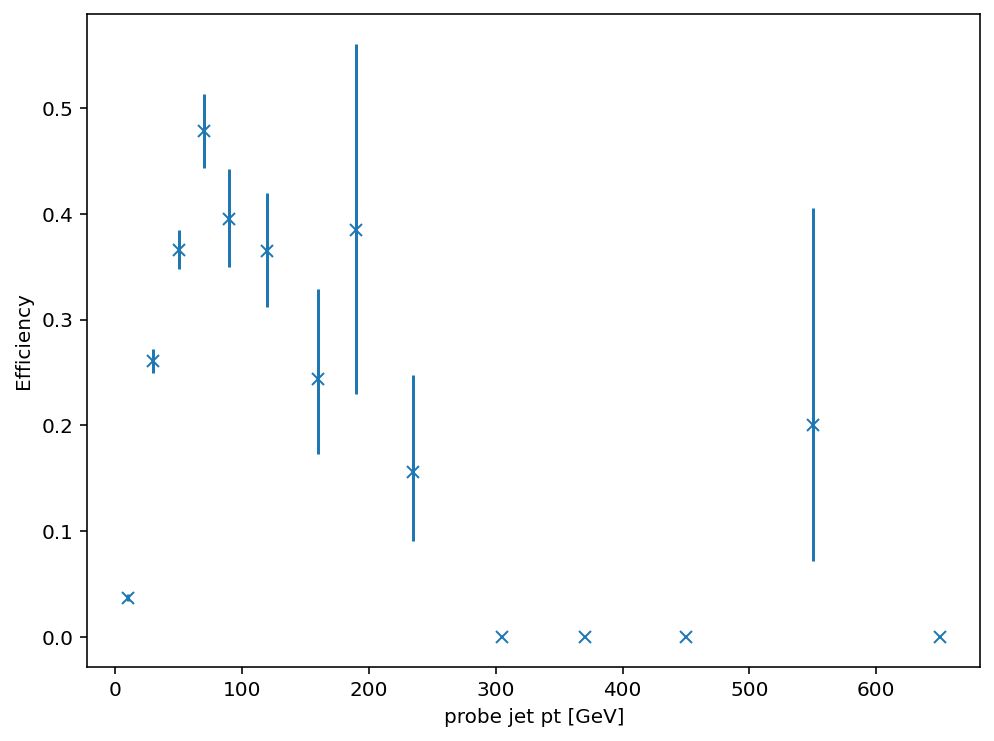

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['numerator'].integrate('dataset'),
               denom=output['denominator'].integrate('dataset'),
                            clear = False,
                            error_opts={'marker': 'x'},
                            unc='clopper-pearson',
                            ax=ax)

In [13]:
print(datasets)

{'A': {'files': ['root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17Sep2018-v2/190903_170031/0000/ffNtuple_100.root', 'root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17Sep2018-v2/190903_170031/0000/ffNtuple_105.root', 'root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17Sep2018-v2/190903_170031/0000/ffNtuple_11.root', 'root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17Sep2018-v2/190903_170031/0000/ffNtuple_102.root', 'root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17Sep2018-v2/190903_170031/0000/ffNtuple_1.root', 'root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17Sep2018-v2/190903_170031/0000/ffNtuple_103.root', 'root://cmseos.fnal.gov//eos/uscms/store/user/pmeloni/ffNtuple4trigger/2018/SingleMuon/Run2018A-17